In [3]:
from src import sgru
from src import gru
from src import switch_utils
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import haiku as hk

In [4]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'

# choose mouse, beta and run time
train_prop = 0.7
param1 = 1
param2 = 3
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
split_dt = "2025-04-17_10-28"
batch_size = 64

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

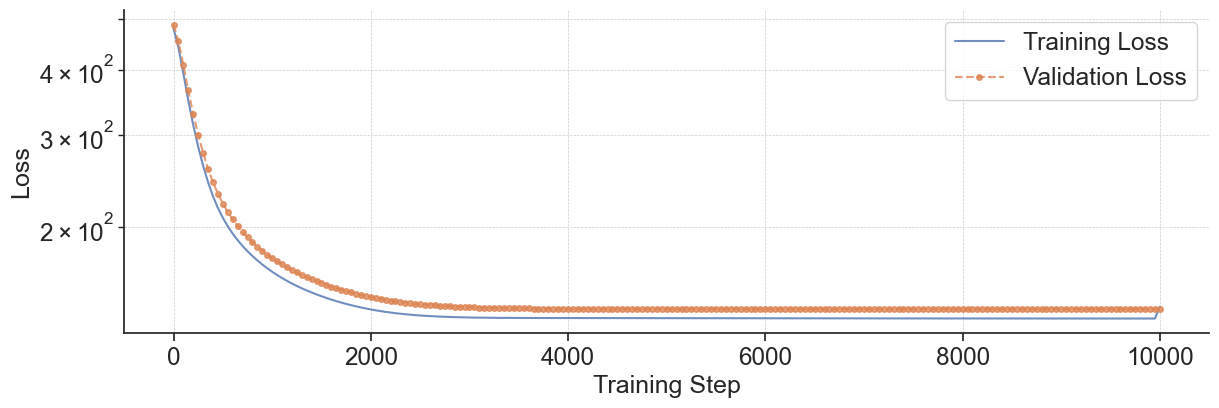

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

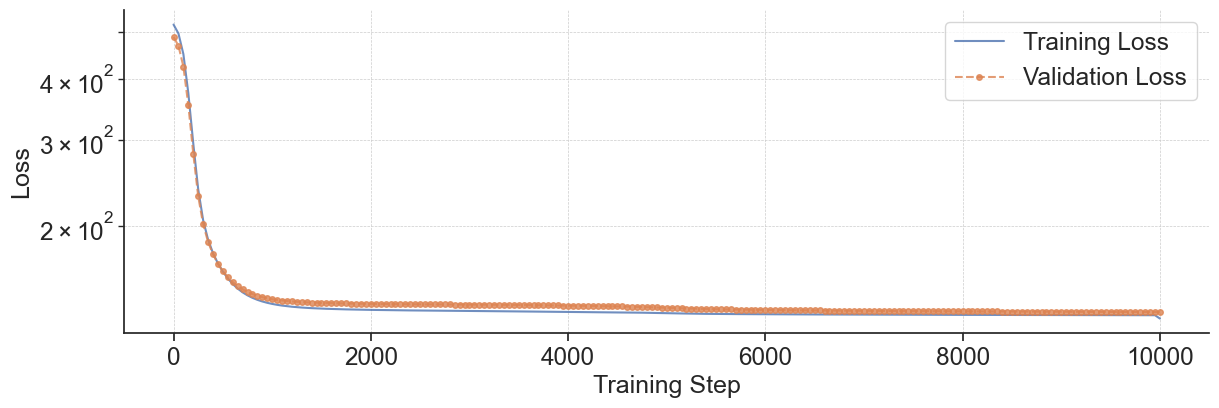

In [5]:
def make_network1():
    return sgru.HkSGRU(param1,2,4)

def make_network2():
    return sgru.HkSGRU(param2,2,4)

params1, opt_state, losses = sgru.train_sgru_network(make_network1, ds_tr, ds_va, n_steps=1e4, do_plot=True)
params2, opt_state, losses = sgru.train_sgru_network(make_network2, ds_tr, ds_va, n_steps=1e4, do_plot=True)

In [87]:
def unroll_network1(xs):
  core = make_network1()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys

def unroll_network2(xs):
  core = make_network2()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys


_, step_hk1 = hk.transform(unroll_network1)
step_hk1 = jax.jit(step_hk1)

_, step_hk2 = hk.transform(unroll_network2)
step_hk2 = jax.jit(step_hk2)

random_key = jax.random.PRNGKey(0)

# first two columns give the probability of left and right (but need to be put through
# softmax for normalising)
output1 = step_hk1(params1, random_key, ds_va._xs)[:,:,:2]
output2 = step_hk2(params2, random_key, ds_va._xs)[:,:,:2]
# sample from the output either greedily or with thompson sampling
sample_type = 'thompson'
y_sampled1 = switch_utils.sampler(output1, sample_type)
y_sampled2 = switch_utils.sampler(output2, sample_type)
# ll = switch_utils.log_likelihood_normalised(ds_va._ys, output)
# parameter_arrays = jax.tree_util.tree_leaves(params)
# total_params = jnp.sum(jnp.array([arr.size for arr in parameter_arrays]))
# print(f"The log likelihood for sgru is {ll:.3f}.")
# print(f"The total number of parameters in the network is: {total_params}")

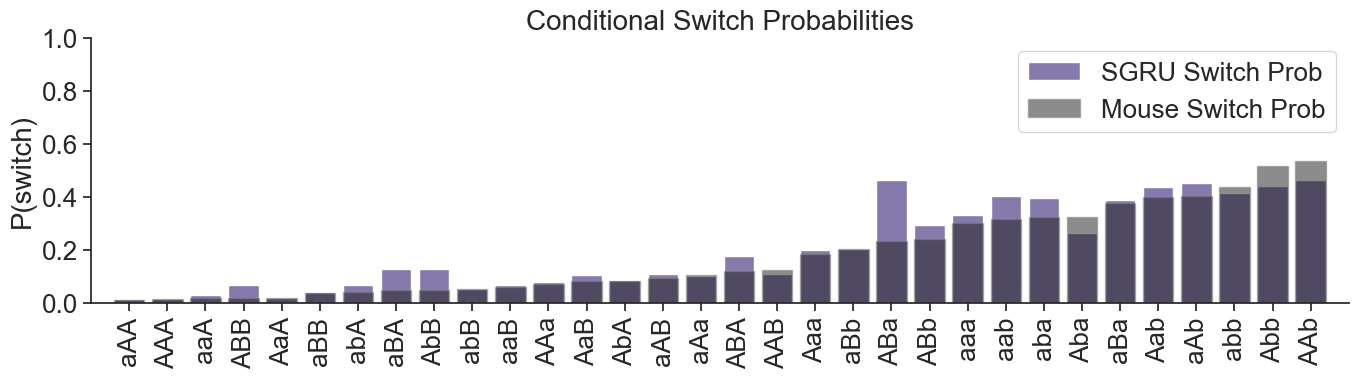

In [107]:
# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_va._xs[1:], y_sampled2[:-1], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set_theme(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color=sns.color_palette()[4], alpha=1, ax=ax, label='SGRU Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
# plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf') 
plt.show()

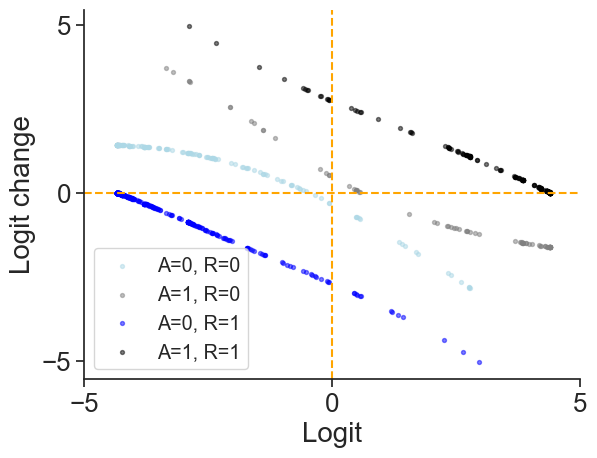

In [50]:
import numpy as np

logits = -jax.nn.log_softmax(output1, axis=2)[:,:,0] + jax.nn.log_softmax(output1, axis=2)[:,:,1]
logits_change = jnp.diff(logits, axis=0)


sess = (2)
logits=logits[:-1]
logits_ma = np.ma.masked_where(ds_va._xs[:-1,:,0]==-1, logits)
logits_change_ma = np.ma.masked_where(ds_va._xs[:-1,:,0]==-1, logits_change)

ac_re_arr = ds_va._xs[:,:,0] + 2* ds_va._xs[:,:,1]
ac_re_mask = np.ma.masked_where(ds_va._xs[:,:,0]==-1, ac_re_arr)

x=logits_ma[:,sess]
y=logits_change_ma[:,sess]
labels = ['A=0, R=0', 'A=1, R=0', 'A=0, R=1', 'A=1, R=1']
colors = ['lightblue', 'gray', 'blue', 'black']
for i in range(4):
    plt.scatter(x=(x[np.argwhere(ac_re_mask[1:,sess]==i)].flatten()), 
                y=y[np.argwhere(ac_re_mask[1:,sess]==i)].flatten(), 
                label=labels[i],
                s=8,
                color=colors[i],
                alpha=0.5)
plt.axhline(0, color='orange', linestyle='--')
plt.axvline(0, color='orange', linestyle='--')
# plt.xlim(-5.1,5.1)
# plt.ylim(-5.1,5.1)
plt.legend(loc='lower left', fontsize='x-small')
sns.despine()
plt.xticks([-5,0,5])
plt.yticks([-5,0,5])
plt.ylabel('Logit change')
plt.xlabel('Logit')
plt.show()

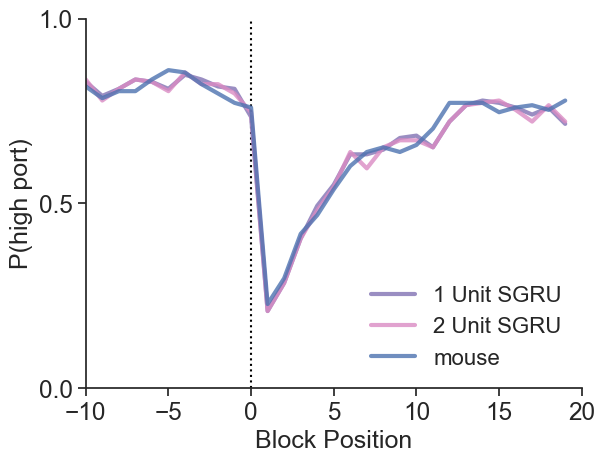

In [101]:

blocks_sim1 = switch_utils.blocker(df_va, y_sampled1[:-1], ds_va._xs[1:,:,0]!=-1, 10, 20)
blocks_sim2 = switch_utils.blocker(df_va, y_sampled2[:-1], ds_va._xs[1:,:,0]!=-1, 10, 20)
blocks = switch_utils.blocker(df_va, ds_va._xs[1:,:,0], ds_va._xs[1:,:,0]!=-1, 10, 20)
block_pos = np.arange(-10,20)
blocks_sim_high1 = blocks_sim1[:,:,:,0] == blocks_sim1[:,:,:,1]
blocks_sim_high2 = blocks_sim2[:,:,:,0] == blocks_sim2[:,:,:,1]
blocks_high = blocks[:,:,:,0] == blocks[:,:,:,1]

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')

ax1.plot(block_pos, np.mean(blocks_sim_high1[:,:,5], axis=1),label='1 Unit SGRU', alpha=0.8, linewidth=3, color=sns.color_palette()[4])
ax1.plot(block_pos, np.mean(blocks_sim_high2[:,:,5], axis=1),label='2 Unit SGRU', alpha=0.8, linewidth=3, color=sns.color_palette()[6])    
ax1.plot(block_pos, np.mean(blocks_high[:,:,5], axis=1),label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
ax1.set(xlim=(-10,20), ylim=(0,1), xlabel='Block Position', ylabel='P(high port)')

sns.despine()

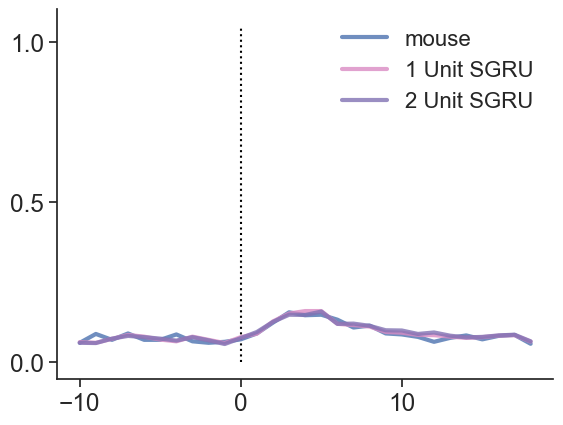

In [70]:
blocks_sim_switch1 = blocks_sim1[1:,:,:,0] != blocks_sim1[:-1,:,:,0]
blocks_sim_switch2 = blocks_sim2[1:,:,:,0] != blocks_sim2[:-1,:,:,0]
blocks_switch = blocks[1:,:,:,0] != blocks[:-1,:,:,0]
block_pos = np.arange(-10, 19)

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')

ax1.plot(block_pos, np.mean(np.mean(blocks_switch[:,:,:], axis=2), axis=1)*2,label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])
ax1.plot(block_pos, np.mean(np.mean(blocks_sim_switch1[:,:,:], axis=2), axis=1),label='1 Unit SGRU', alpha=0.8, linewidth=3, color=sns.color_palette()[6])    
ax1.plot(block_pos, np.mean(np.mean(blocks_sim_switch2[:,:,:], axis=2), axis=1),label='2 Unit SGRU', alpha=0.8, linewidth=3, color=sns.color_palette()[4])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
# ax1.set(xlim=(-1.5,5), ylim=(0,0.5), xlabel='Block Position', ylabel='P(switch)')

sns.despine()

In [68]:
np.shape(blocks_sim_switch2)

(29, 50, 26)